In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels
import statsmodels.api as sm
from sktime.forecasting.arima import AutoARIMA
import seaborn as sns
import math
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('./PRSA_data_2010.1.1-2014.12.31.csv')
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [3]:
df.isna().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [4]:
df = df.dropna()
df.dtypes

No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['cbwd'] = le.fit_transform(df['cbwd'])

df = df.iloc[:,1:] # remove row number column
df

/tmp/ipykernel_284/2253441171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cbwd'] = le.fit_transform(df['cbwd'])


,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,2010,1,2,0,129.0,-16,-4.0,1020.0,2,1.79,0,0
25,2010,1,2,1,148.0,-15,-4.0,1020.0,2,2.68,0,0
26,2010,1,2,2,159.0,-11,-5.0,1021.0,2,3.57,0,0
27,2010,1,2,3,181.0,-7,-5.0,1022.0,2,5.36,1,0
28,2010,1,2,4,138.0,-7,-5.0,1022.0,2,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014,12,31,19,8.0,-23,-2.0,1034.0,1,231.97,0,0
43820,2014,12,31,20,10.0,-22,-3.0,1034.0,1,237.78,0,0
43821,2014,12,31,21,10.0,-22,-3.0,1034.0,1,242.70,0,0
43822,2014,12,31,22,8.0,-22,-4.0,1034.0,1,246.72,0,0


In [6]:
# convert to datetime
df['datetime'] = pd.to_datetime(df[['year','month','day','hour']], format='%Y/%m/%d, %H')

In [7]:
df = df.drop(['year','month','day','hour'], axis = 1)
df = df.reset_index()
df = df[['datetime','pm2.5','DEWP','PRES','cbwd','Iws','Is','Ir']]
df

,datetime,pm2.5,DEWP,PRES,cbwd,Iws,Is,Ir
0,2010-01-02 00:00:00,129.0,-16,1020.0,2,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,1020.0,2,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,1021.0,2,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,1022.0,2,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,1022.0,2,6.25,2,0
...,...,...,...,...,...,...,...,...
41752,2014-12-31 19:00:00,8.0,-23,1034.0,1,231.97,0,0
41753,2014-12-31 20:00:00,10.0,-22,1034.0,1,237.78,0,0
41754,2014-12-31 21:00:00,10.0,-22,1034.0,1,242.70,0,0
41755,2014-12-31 22:00:00,8.0,-22,1034.0,1,246.72,0,0


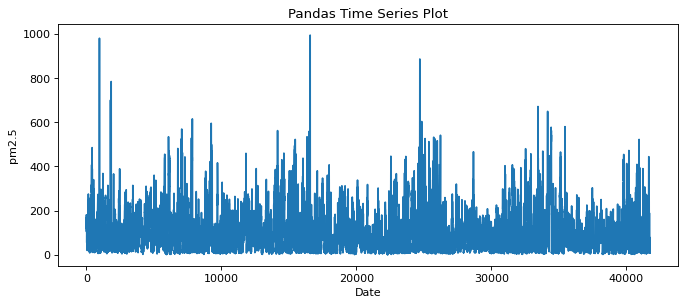

In [8]:
x = df['datetime']
y = df['pm2.5']
plt.figure(figsize = (10, 4), dpi = 80)
plt.xlabel("Date")
plt.ylabel("pm2.5")
plt.title("Pandas Time Series Plot")
plt.plot(range(len(x)), y)
plt.show()

## Implement Augmented Dickey-Fuller Test 
Check if the data is stationary or non-stationary

In [9]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
    print(out.to_string())   
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        

In [10]:
tmp_df = df.drop('datetime',axis=1)
for item in tmp_df:
    print('ADF test result of {}:'.format(item))
    adf_test(df[item])
    print('----------------------------------------------')

ADF test result of pm2.5:
Augmented Dickey-Fuller Test: 
ADF test statistic        -20.606825
p-value                     0.000000
# lags used                54.000000
# observations          41702.000000
critical value (1%)        -3.430507
critical value (5%)        -2.861609
critical value (10%)       -2.566807
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
----------------------------------------------
ADF test result of DEWP:
Augmented Dickey-Fuller Test: 
ADF test statistic     -5.963564e+00
p-value                 2.012344e-07
# lags used             5.500000e+01
# observations          4.170100e+04
critical value (1%)    -3.430507e+00
critical value (5%)    -2.861609e+00
critical value (10%)   -2.566807e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
----------------------------------------------
ADF test result of PRES:
Augmented Dickey-Fuller Test

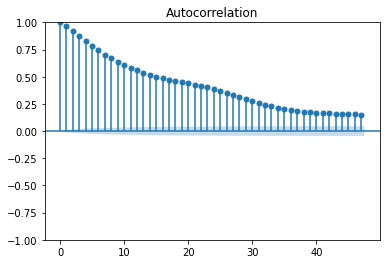

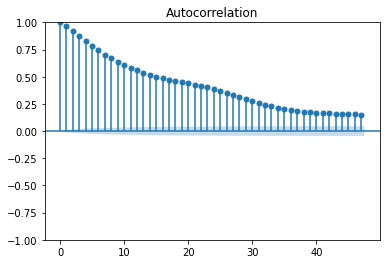

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['pm2.5'])

## Split the data into train and test

In [12]:
feature_col = ['DEWP','PRES','cbwd','Iws','Is','Ir']
target_col = ['pm2.5']

train_size = int(0.70 * len(df))

multivariate_df = df[['datetime'] + target_col + feature_col].copy()
multivariate_df.columns = ['ds', 'y'] + feature_col

train = multivariate_df.iloc[:train_size, :]
X_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
X_test, y_test = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

## Modeling 


### 1. VAR

In [13]:
df_diff = df.diff().dropna()

X = df_diff[['pm2.5','DEWP','PRES','cbwd','Iws','Is','Ir']]

thresh = int(len(X)*0.3)
var_train = X[:thresh]
var_test = X[-thresh:]

In [14]:
var_model = VAR(var_train)
results_aic = []
for p in range(1,10):
    results = var_model.fit(p)
    results_aic.append(results.aic)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


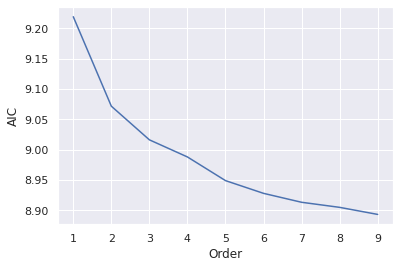

In [15]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [16]:
result = var_model.fit(10)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Apr, 2022
Time:                     03:53:50
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    9.17298
Nobs:                     12516.0    HQIC:                   8.97658
Log likelihood:          -179376.    FPE:                    7170.63
AIC:                      8.87775    Det(Omega_mle):         6892.25
--------------------------------------------------------------------
Results for equation pm2.5
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.024082         0.226675           -0.106           0.915
L1.pm2.5          0.103602         0.009028           11.475           0.000
L1.DEWP           1.906238         0.177276           10.753           0.000

In [17]:
lagged_values = var_train.values[:]

forecast = pd.DataFrame(results.forecast(y=lagged_values, steps=len(var_test)), index = var_test.index, columns= ['pm2.5','DEWP','PRES','cbwd','Iws','Is','Ir'])
forecast

,pm2.5,DEWP,PRES,cbwd,Iws,Is,Ir
29231,-4.676569,-0.036504,-0.088650,0.006963,-0.441167,0.005068,0.046999
29232,-2.619357,-0.071549,-0.112074,0.015349,-0.844026,0.008171,-0.021045
29233,-0.957402,0.037856,0.029645,-0.088028,-0.774844,0.005257,0.098523
29234,-1.869542,-0.036252,0.049094,0.076275,0.261161,0.002334,-0.052198
29235,-1.748297,0.073814,0.050329,-0.050980,-1.070132,0.002484,0.038854
...,...,...,...,...,...,...,...
41752,-0.000350,0.002572,-0.001822,0.000002,0.002337,-0.000010,0.000014
41753,-0.000350,0.002572,-0.001822,0.000002,0.002337,-0.000010,0.000014
41754,-0.000350,0.002572,-0.001822,0.000002,0.002337,-0.000010,0.000014
41755,-0.000350,0.002572,-0.001822,0.000002,0.002337,-0.000010,0.000014


In [18]:
forecast['pm2.5'] = df['pm2.5'].iloc[-thresh-1] + forecast['pm2.5'].cumsum()
forecast['DEWP'] = df['DEWP'].iloc[-thresh-1] + forecast['DEWP'].cumsum() 
forecast['PRES'] = df['PRES'].iloc[-thresh-1] + forecast['PRES'].cumsum() 
forecast['cbwd'] = df['cbwd'].iloc[-thresh-1] + forecast['cbwd'].cumsum() 
forecast['Iws'] = df['Iws'].iloc[-thresh-1] + forecast['Iws'].cumsum() 
forecast['Is'] = df['Is'].iloc[-thresh-1] + forecast['Is'].cumsum() 
forecast['Ir'] = df['Ir'].iloc[-thresh-1] + forecast['Ir'].cumsum() 
forecast

,pm2.5,DEWP,PRES,cbwd,Iws,Is,Ir
29231,56.323431,20.963496,1004.911350,2.006963,22.788833,0.005068,0.046999
29232,53.704073,20.891947,1004.799276,2.022312,21.944808,0.013239,0.025954
29233,52.746671,20.929803,1004.828921,1.934284,21.169964,0.018496,0.124477
29234,50.877129,20.893551,1004.878015,2.010560,21.431125,0.020830,0.072278
29235,49.128832,20.967364,1004.928344,1.959580,20.360993,0.023314,0.111133
...,...,...,...,...,...,...,...
41752,47.329327,53.133435,982.267947,2.024708,49.916958,-0.108059,0.295314
41753,47.328977,53.136007,982.266125,2.024710,49.919295,-0.108069,0.295328
41754,47.328627,53.138578,982.264303,2.024712,49.921633,-0.108079,0.295342
41755,47.328277,53.141150,982.262481,2.024715,49.923970,-0.108089,0.295356


In [19]:
score_rmse = math.sqrt(mean_squared_error(var_test, forecast))
print('RMSE: {}'.format(score_rmse))

RMSE: 376.7049816762446


### 2. ARIMA

In [20]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(y_train, order=(1,1,1))
arima_model = arima_model.fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                29229
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -135779.968
Date:                Sun, 17 Apr 2022   AIC                         271565.936
Time:                        03:53:52   BIC                         271590.785
Sample:                             0   HQIC                        271573.919
                              - 29229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1424      0.008    -17.505      0.000      -0.158      -0.126
ma.L1          0.3256      0.008     43.138      0.000       0.311       0.340
sigma2       634.9759      0.844    752.725      0.0

In [21]:
# Predict on test set
# arima_y_pred = arima_model.predict(start=X_train.shape[0],end=(X_train.shape[0]+X_test.shape[0]-1))
arima_y_pred = arima_model.forecast(12528)
# Evaludate the model
score_mae = mean_absolute_error(y_test, arima_y_pred)
score_rmse = math.sqrt(mean_squared_error(y_test, arima_y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 102.2829744174831


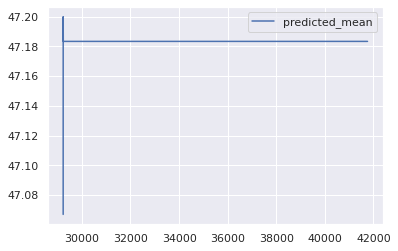

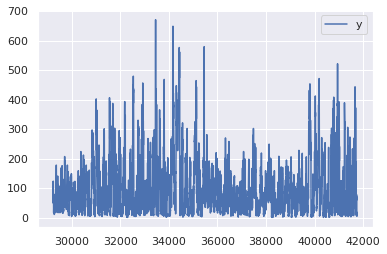

In [22]:
arima_y_pred.plot(legend=True)
y_test.plot(legend=True)
plt.show()

### 3. SARIMAX

In [23]:
sari_model = sm.tsa.statespace.SARIMAX(y_train, trend='c', order=(1,1,(1,0,0,1)))
sari_model = sari_model.fit(disp=False)
print(sari_model.summary())

                                 SARIMAX Results                                 
Dep. Variable:                         y   No. Observations:                29229
Model:             SARIMAX(1, 1, [1, 4])   Log Likelihood             -135779.830
Date:                   Sun, 17 Apr 2022   AIC                         271569.659
Time:                           03:54:11   BIC                         271611.074
Sample:                                0   HQIC                        271582.964
                                 - 29229                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0029      0.205     -0.014      0.989      -0.405       0.399
ar.L1         -0.1440      0.008    -17.105      0.000      -0.160      -0.127
ma.L1          0.3272      0

In [24]:
sari_y_pred = sari_model.forecast(12528)

# Evaludate the model
score_mae = mean_absolute_error(y_test, sari_y_pred)
score_rmse = math.sqrt(mean_squared_error(y_test, sari_y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 111.05757190966203


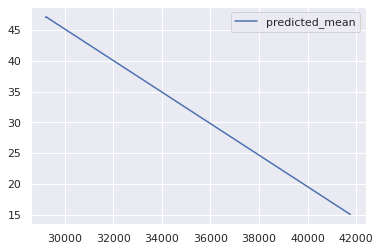

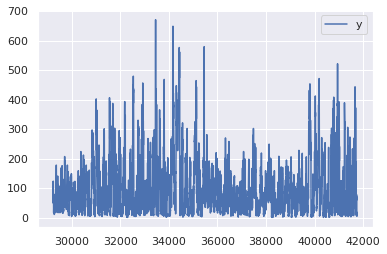

In [25]:
sari_y_pred.plot(legend=True)
y_test.plot(legend=True)
plt.show()

### 4. PROPHET

In [26]:
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import math

# Train the model
pro_model = Prophet()
pro_model.add_regressor('DEWP')
pro_model.add_regressor('PRES')
pro_model.add_regressor('cbwd')
pro_model.add_regressor('Iws')
# model.add_regressor('Is')
# model.add_regressor('Ir')

# Fit the model with train set
pro_model.fit(train)

# Predict on valid set
pro_y_pred = pro_model.predict(X_test)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, pro_y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_test, pro_y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -139.853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       63176.4   0.000573654       1489.53           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       63247.8   0.000266897       1115.86      0.2338      0.2338      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       63266.8    0.00696251       1294.64      0.8086      0.8086      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       63284.2   0.000386751       409.506      0.9821      0.9821      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       63294.9   0.000726232         599.3      0.3741           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


RMSE: 68.81045142066871


<function matplotlib.pyplot.show(close=None, block=None)>

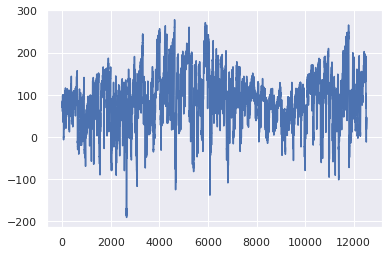

In [27]:
pro_y_pred['yhat'].plot()
plt.show

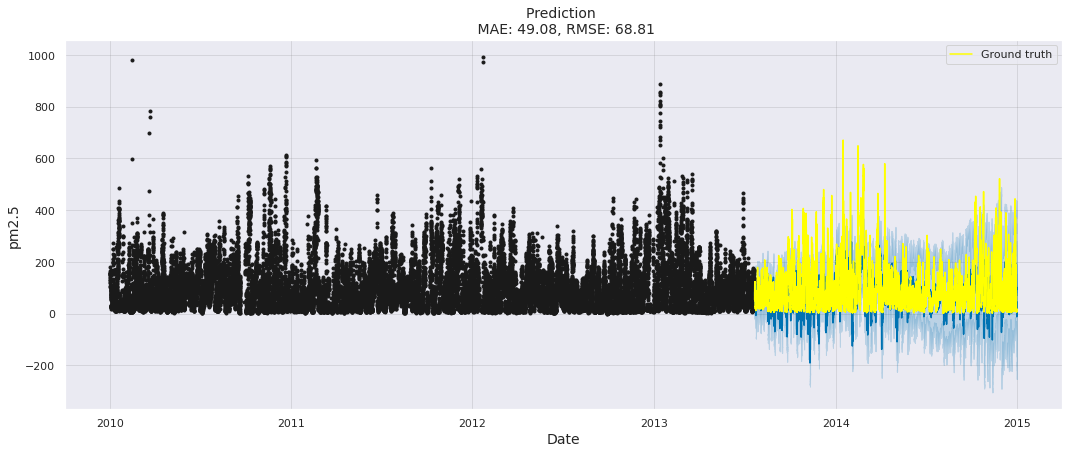

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

pro_model.plot(pro_y_pred, ax=ax)
sns.lineplot(x=X_test['ds'], y=y_test['y'], ax=ax, color='yellow', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='pm2.5', fontsize=14)

plt.show()

### 5. DECISION TREE

In [29]:
# fit final model

X_train['ds'] = pd.to_numeric(pd.to_datetime(X_train['ds']))
X_test['ds'] = pd.to_numeric(pd.to_datetime(X_test['ds']))

tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=100000)
tree_model.fit(X_train, y_train)
tree_y_pred = tree_model.predict(X_test)


cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(estimator = tree_model, X = X_train, y = y_train, scoring='neg_mean_absolute_error',cv=cv, n_jobs=-1)

print('RMSE:',sqrt(mean_squared_error(y_test, tree_y_pred))) 
print('RMSE(10-fold cross-validation):',sqrt(mean(absolute(scores))))

RMSE: 102.64841838496523
RMSE(10-fold cross-validation): 6.128644469011862


### 6. Random Forest Regression

In [30]:
rf_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='sqrt', min_samples_leaf=4,
           min_samples_split=6, n_estimators=100)
rf_model.fit(X_train, y_train['y'])
rf_y_pred = rf_model.predict(X_test)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(estimator = rf_model, X = X_train, y = y_train['y'], scoring='neg_mean_absolute_error',cv=cv, n_jobs=-1)

print('RMSE:',sqrt(mean_squared_error(y_test, rf_y_pred))) 
print('RMSE(10-fold cross-validation):',sqrt(mean(absolute(scores))))

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equi

RMSE: 88.55510392080288
RMSE(10-fold cross-validation): 5.7035994233910206


<function matplotlib.pyplot.show(close=None, block=None)>

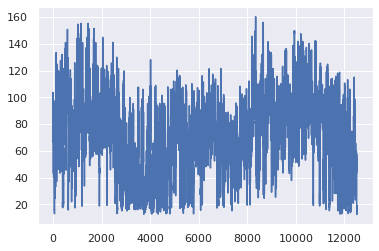

In [31]:
plt.plot(rf_y_pred)
plt.show